# Trying tslearn

In [34]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='10m',facecolor='grey')
import matplotlib as mpl

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax

from tslearn.utils import to_time_series_dataset

### Open dataset

In [2]:
file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1607013925530.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, time: 8760)
Coordinates:
  * time                                           (time) datetime64[ns] 2019-01-01T00:30:00 ... 2019-12-31T23:30:00
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
Data variables:
    sea_surface_warm_layer_temperature_difference  (time, lat, lon) float32 ...
    sea_surface_cool_skin_temperature_difference   (time, lat, lon) float32 ...
    analysed_sst                                   (time, lat, lon) float32 ...
    mask                                           (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      Global Diurnal Skin SST Analysis, L4 OSTIA, 0...
    summary:                    A merged, multi-sensor L4 skin SST product
    references:                 While J., Martin M.; 2013;  Development of a ...
    institution:                UKMO
    history:                    See source and creation_date attributees
    comment:                    WARNING Some applications are unable to prope...
    license:                    These data are available free of charge under...
    id:                         UKMO-L4LRskin_GLOB-OSTIAdiu
    naming_authority:           org.ghrsst
    product_version:            1.2
    uuid:                       dd7afcc1-acf0-4a0f-9407-19d49b470b7b
    gds_version_id:             2.4
    netcdf_version_id:          4.1
    date_created:               20201203T081437Z
    start_time:                 20201202T000000Z
    time_coverage_start:        20201202T000000Z
    stop_time:                  20201202T235959Z
    time_coverage_end:          20201202T235959Z
    file_quality_level:         3
    source:                     NAVO-L2P-AVHRR19_G, OSPO-L2P-GOES15, SEVIRI_S...
    platform:                   NOAA-19, GOES15, MSG2, MTSAT2
    sensor:                     AVHRR, Imager, SEVIRI, Imager
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    metadata_link:              Not yet available
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    westernmost_longitude:      -180.0
    easternmost_longitude:      180.0
    southernmost_latitude:      -90.0
    northernmost_latitude:      90.0
    spatial_resolution:         0.25 degree
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    acknowledgment:             Please acknowledge the use of these data with...
    creator_name:               Met Office as part of CMEMS
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    creator_url:                http://marine.copernicus.eu/
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    History:                    Translated to CF-1.0 Conventions by Netcdf-Ja...
    geospatial_lat_min:         30.125
    geospatial_lat_max:         46.125
    geospatial_lon_min:         -4.875
    geospatial_lon_max:         42.875

### Preprocessing

1) weekly mean

In [3]:
ds = ds.groupby("time.week").mean()
ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values
/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, week: 52)
Coordinates:
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
  * week                                           (week) int64 1 2 3 ... 51 52
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, lat, lon) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (week, lat, lon) float32 nan ... 0.0
    analysed_sst                                   (week, lat, lon) float32 nan ... 275.3912
    mask                                           (week, lat, lon) float32 2.0 ... 1.0

2) Reduce lat lon dimension to one dimension

In [4]:
sampling_dims = list(ds.dims)
sampling_dims.remove('week')
sampling_dims
X = ds.stack({'sampling': sampling_dims})
X

<xarray.Dataset>
Dimensions:                                        (sampling: 12480, week: 52)
Coordinates:
  * week                                           (week) int64 1 2 3 ... 51 52
  * sampling                                       (sampling) MultiIndex
  - lat                                            (sampling) float64 30.12 ... 46.12
  - lon                                            (sampling) float64 -4.875 ... 42.88
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, sampling) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (week, sampling) float32 nan ... 0.0
    analysed_sst                                   (week, sampling) float32 nan ... 275.3912
    mask                                           (week, sampling) float32 2.0 ... 1.0

3) Delate NaNs in land

In [ ]:
stacked_mask = X['mask']
stacked_mask

In [ ]:
X = X.where(stacked_mask == 1, drop=True)
X

In [7]:
Xn = X['analysed_sst'].where(~X['analysed_sst'].isnull(),drop=True).to_dataset()
Xn

<xarray.Dataset>
Dimensions:       (sampling: 5741, week: 52)
Coordinates:
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
Data variables:
    analysed_sst  (week, sampling) float32 291.3304 291.29144 ... 275.3912

4) to_time_series_dataset

In [15]:
formatted_dataset = to_time_series_dataset(Xn['analysed_sst'].values.transpose())
formatted_dataset.shape

(5741, 52, 1)

5) Scaler

In [17]:
scaled_dataset = TimeSeriesScalerMinMax(value_range=(0, 1.)).fit_transform(formatted_dataset)
scaled_dataset.shape

(5741, 52, 1)

### Model

In [20]:
n_clusters = 5
km = TimeSeriesKMeans(n_clusters=n_clusters, max_iter=50)
pred = km.fit_predict(scaled_dataset)
pred.shape

(5741,)

In [21]:
Xn['cluster'] = xr.DataArray(pred,dims=['sampling'])
Xn

<xarray.Dataset>
Dimensions:       (sampling: 5741, week: 52)
Coordinates:
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
Data variables:
    analysed_sst  (week, sampling) float32 291.3304 291.29144 ... 275.3912
    cluster       (sampling) int64 2 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1

new dataset

In [30]:
ds_labels = Xn.unstack()
ds_labels = ds_labels .sortby(['lat','lon'])
ds_labels

<xarray.Dataset>
Dimensions:       (lat: 64, lon: 191, week: 52)
Coordinates:
  * week          (week) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * lat           (lat) float64 30.38 30.62 30.88 31.12 ... 45.62 45.88 46.12
  * lon           (lon) float64 -4.875 -4.625 -4.375 ... 42.38 42.62 42.88
Data variables:
    analysed_sst  (week, lat, lon) float32 nan nan nan nan ... nan nan 275.3912
    cluster       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan 1.0

### Plot

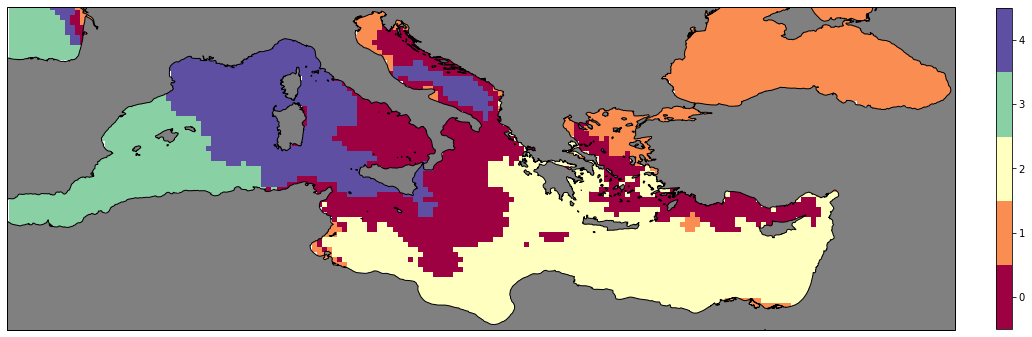

In [31]:
fig=plt.figure(figsize=(18,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(land_feature, edgecolor='black')
ax.set_extent([-5, 42, 30, 46], crs=ccrs.PlateCarree())
plt.pcolormesh(ds_labels['lon'], ds_labels['lat'], ds_labels['cluster'], vmin=0, vmax=n_clusters-1, cmap=plt.cm.get_cmap('Spectral', n_clusters))
plt.colorbar(ticks=range(n_clusters),fraction=0.016, pad=0.04)
plt.clim([-0.5,4.5])
plt.show()

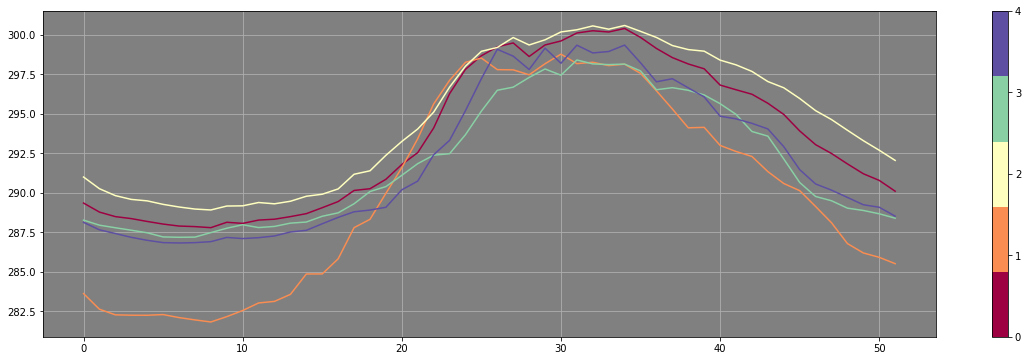

In [35]:
cmap=plt.cm.get_cmap('Spectral', n_clusters)
plt.figure(figsize=(20,6))
plt.gca().set_facecolor('grey')
plt.grid()
for yi in range(n_clusters):
    plt.plot(Xn['analysed_sst'].where(Xn['cluster']==yi, drop=True).mean('sampling'),color=cmap(yi))

norm = mpl.colors.Normalize(vmin=0,vmax=n_clusters-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(n_clusters))    
plt.show()